C:\Users\jayka\AppData\Local\Temp\ipykernel_3096\2033103421.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
c:\Users\jayka\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
c:\Users\jayka\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
C:\Users\jayka\AppData\Local\Temp\ipykernel_3096\2033103421.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

          ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2018-01-06  11182.553650 -23586.685809  27184.522587  11182.553650   
1 2018-01-07  11191.918188 -15300.476016  33372.647027  11191.918188   
2 2018-01-08  11201.282725 -19236.497110  33333.819750  11201.282725   
3 2018-01-09  11210.647262 -18510.607307  34142.321242  11210.647262   
4 2018-01-10  11220.011800 -20947.604631  29674.394735  11220.011800   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  11182.553650    -9872.258987          -9872.258987          -9872.258987   
1  11191.918188    -2575.780155          -2575.780155          -2575.780155   
2  11201.282725    -4430.940693          -4430.940693          -4430.940693   
3  11210.647262    -3432.649387          -3432.649387          -3432.649387   
4  11220.011800    -7269.377915          -7269.377915          -7269.377915   

         daily  ...       weekly  weekly_lower  weekly_upper       yearly  \
0 -3752.390577 

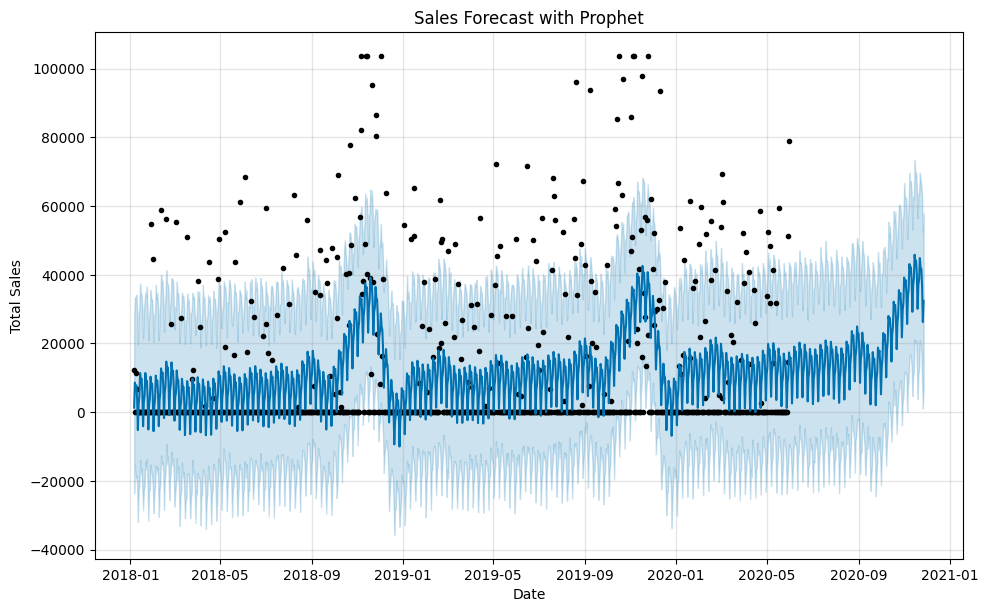

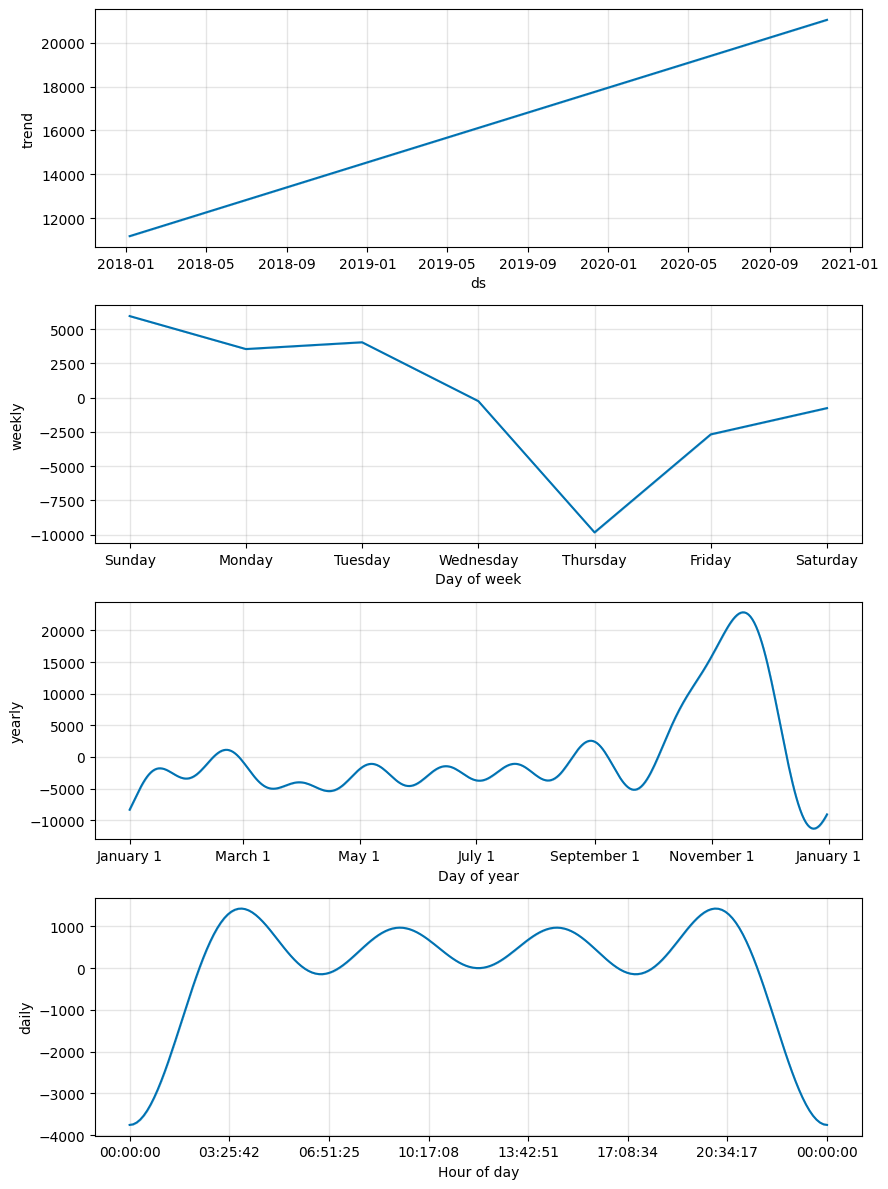

             ds          yhat    yhat_lower    yhat_upper
1052 2020-11-23  41882.398367  19073.441297  67324.910945
1053 2020-11-24  41718.520649  17356.625721  66088.262103
1054 2020-11-25  36663.774828   8863.495172  62927.848813
1055 2020-11-26  26221.020155   1032.000181  52484.916361
1056 2020-11-27  32397.491279   6584.311912  57769.169246


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

# Step 1: Load the data
df = pd.read_csv(r'C:\Users\jayka\Downloads\AI Space\Final_Project\Auto Sales data.csv')

# Step 2: Preprocess the data
# Convert 'ORDERDATE' to datetime format
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# Aggregate the data by day, summing the SALES for each day
daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()

# Rename the columns for Prophet: 'ds' for date and 'y' for sales (target variable)
daily_sales.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)

# Step 3: Ensure continuous date range (fill in missing dates)
# Create a continuous date range from the minimum to maximum date in the dataset
full_date_range = pd.date_range(start=daily_sales['ds'].min(), end=daily_sales['ds'].max(), freq='D')

# Merge the full date range with the existing sales data to include missing dates
# Missing dates will have NaN for sales
daily_sales_full = pd.DataFrame({'ds': full_date_range})
daily_sales_full = pd.merge(daily_sales_full, daily_sales, on='ds', how='left')

Q1 = daily_sales_full.quantile(0.25)
Q3 = daily_sales_full.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_sales_full = daily_sales_full.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Replace NaN sales with 0 (since no sales occurred on those dates)
daily_sales_full['y'].fillna(0, inplace=True)


# Step 4: Initialize the Prophet Model
model = Prophet(daily_seasonality=True)

# Step 5: Fit the model to your data
model.fit(daily_sales_full)

# Step 6: Create future dates for prediction
# Generate future dates for the next 180 days
future_dates = model.make_future_dataframe(periods=180, freq='D')

# Step 7: Predict the future sales
forecast = model.predict(future_dates)
print(forecast.head())

# Merge the forecast with actual values for accuracy calculation
merged_data = pd.merge(daily_sales_full, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate accuracy metrics
mae = mean_absolute_error(merged_data['y'], merged_data['yhat'])
mse = mean_squared_error(merged_data['y'], merged_data['yhat'])
rmse = mse**0.5
mape = (abs((merged_data['y'] - merged_data['yhat']) / merged_data['y']).replace([float('inf'), -float('inf')], 0).mean()) * 100

# Print the accuracy metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse}")


# Step 8: Visualize the results
# Plot the forecast
model.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# Step 9: Visualize the forecast components (Trend, Seasonality)
model.plot_components(forecast)
plt.show()

# Optional: Save the forecast data (including forecasted values)
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # Extract the relevant columns
forecast_data.to_csv('sales_forecast.csv', index=False)

# Show the forecasted data (optional)
print(forecast_data.tail())  # View the last rows of the forecasted data
